In [3]:
# ============================================================
# 1) IMPORTS + CONFIG
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

DATA_PATH = "../ResearchData/Respiratory_Sample_data_randamized.csv"

TRAIN_YEARS = [2019, 2020, 2021, 2022]
TEST_YEAR = 2023

TOP_N_NATIONALITIES_MODEL = 25   # for stable GLM
TOP_N_NATIONALITIES_PLOT  = 15   # for readable nationality plot

DAYS_IN_YEAR = 365
HORIZON_30D = 30
HORIZON_15D = 15


In [4]:
# ============================================================
# 2) LOAD + CLEAN
# ============================================================
def load_and_clean(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # Annual count target: treat_consluation includes '-' meaning 0
    y = df["treat_consluation"].astype(str).str.strip().replace({"-": "0", "": "0"})
    df["y_annual"] = pd.to_numeric(y, errors="coerce").fillna(0).astype(int)

    # Exposure
    df["Earned_Days"] = pd.to_numeric(df["Earned_Days"], errors="coerce")
    df = df[df["Earned_Days"].notna() & (df["Earned_Days"] > 0)].copy()

    # Clean fields
    df["AGEBAND"] = df["AGEBAND"].astype(str).str.strip()
    df = df[df["AGEBAND"].ne("Out of range")].copy()

    df["gender"] = df["gender"].astype(str).str.strip()
    df["nationality"] = df["nationality"].astype(str).str.strip()
    df["dependency"] = df["dependency"].astype(str).str.strip()

    return df[["treat_year", "AGEBAND", "gender", "nationality", "dependency",
               "y_annual", "Earned_Days"]].copy()

df = load_and_clean(DATA_PATH)
df.head(), df.shape


(   treat_year  AGEBAND gender nationality dependency  y_annual  Earned_Days
 0        2019  025-029      M    NEPALESE     MEMBER         0   691.603725
 1        2019  020-024      M    NEPALESE     MEMBER         0   385.626908
 2        2019  035-039      M    NEPALESE     MEMBER         0     5.569399
 3        2019  030-034      M    NEPALESE     MEMBER         0     5.478361
 4        2019  025-029      M    NEPALESE     MEMBER         0     4.026355,
 (145399, 7))

In [5]:
# ============================================================
# 3) BUCKETING (stability)
# ============================================================
def add_buckets(df: pd.DataFrame, top_n_nat: int) -> pd.DataFrame:
    out = df.copy()

    # Nationality: keep top-N by exposure, rest -> OTHER
    top_nat = (
        out.groupby("nationality")["Earned_Days"]
           .sum()
           .sort_values(ascending=False)
           .head(top_n_nat)
           .index
    )
    out["nationality_grp"] = np.where(out["nationality"].isin(top_nat), out["nationality"], "OTHER")

    # Dependency: stable buckets
    dep = out["dependency"]
    out["dependency_grp"] = np.select(
        [dep.eq("MEMBER"), dep.isin(["SPOUSE", "CHILD"]), dep.eq("DEPENDENT")],
        ["MEMBER", "SPOUSE_CHILD", "DEPENDENT"],
        default="OTHER"
    )
    return out

df = add_buckets(df, top_n_nat=TOP_N_NATIONALITIES_MODEL)
df[["nationality", "nationality_grp", "dependency", "dependency_grp"]].head()


,nationality,nationality_grp,dependency,dependency_grp
0,NEPALESE,NEPALESE,MEMBER,MEMBER
1,NEPALESE,NEPALESE,MEMBER,MEMBER
2,NEPALESE,NEPALESE,MEMBER,MEMBER
3,NEPALESE,NEPALESE,MEMBER,MEMBER
4,NEPALESE,NEPALESE,MEMBER,MEMBER


In [6]:
# ============================================================
# 4) AGGREGATE TO RISK CELLS (fast GLM + ML)
# ============================================================
def aggregate_cells(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.groupby(["treat_year", "AGEBAND", "gender", "nationality_grp", "dependency_grp"], as_index=False)
          .agg(
              y_annual=("y_annual", "sum"),
              Earned_Days=("Earned_Days", "sum")
          )
    )

cells = aggregate_cells(df)
cells.head(), cells.shape


(   treat_year  AGEBAND gender nationality_grp dependency_grp  y_annual  \
 0        2019  000-014      F        AMERICAN   SPOUSE_CHILD       364   
 1        2019  000-014      F     BANGLADESHI   SPOUSE_CHILD        91   
 2        2019  000-014      F         BRITISH   SPOUSE_CHILD       425   
 3        2019  000-014      F        CANADIAN   SPOUSE_CHILD       244   
 4        2019  000-014      F         COMORAN   SPOUSE_CHILD       526   
 
    Earned_Days  
 0   405.113424  
 1    78.639316  
 2   715.422314  
 3   295.018195  
 4   625.702624  ,
 (6248, 7))

In [7]:
# ============================================================
# 5) FIT BASELINE GLM + PREDICT (annual + 30d + 15d)
# ============================================================
def fit_poisson_glm(train_cells: pd.DataFrame):
    formula = "y_annual ~ C(AGEBAND) + C(gender) + C(nationality_grp) + C(dependency_grp)"
    model = smf.glm(
        formula=formula,
        data=train_cells,
        family=sm.families.Poisson(),
        offset=np.log(train_cells["Earned_Days"])
    ).fit(maxiter=100)
    return model

def add_glm_predictions(df_cells: pd.DataFrame, model) -> pd.DataFrame:
    out = df_cells.copy()
    out["glm_pred_annual"] = model.predict(out, offset=np.log(out["Earned_Days"]))
    out["glm_pred_30d"] = out["glm_pred_annual"] * (HORIZON_30D / DAYS_IN_YEAR)
    out["glm_pred_15d"] = out["glm_pred_annual"] * (HORIZON_15D / DAYS_IN_YEAR)
    return out

train_cells = cells[cells["treat_year"].isin(TRAIN_YEARS)].copy()
test_cells  = cells[cells["treat_year"] == TEST_YEAR].copy()

glm_model = fit_poisson_glm(train_cells)
print(glm_model.summary().tables[0])

test_glm = add_glm_predictions(test_cells, glm_model)
test_glm.head()


                 Generalized Linear Model Regression Results                  
Dep. Variable:               y_annual   No. Observations:                 4953
Model:                            GLM   Df Residuals:                     4912
Model Family:                 Poisson   Df Model:                           40
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51828.
Date:                Sun, 21 Dec 2025   Deviance:                       86396.
Time:                        13:43:56   Pearson chi2:                 9.20e+04
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         


,treat_year,AGEBAND,gender,nationality_grp,dependency_grp,y_annual,Earned_Days,glm_pred_annual,glm_pred_30d,glm_pred_15d
4953,2023,000-014,F,AMERICAN,SPOUSE_CHILD,346,462.500122,282.197680,23.194330,11.597165
4954,2023,000-014,F,BANGLADESHI,SPOUSE_CHILD,33,58.257330,25.052264,2.059090,1.029545
4955,2023,000-014,F,BRITISH,SPOUSE_CHILD,413,678.855052,309.522030,25.440167,12.720083
4956,2023,000-014,F,CANADIAN,SPOUSE_CHILD,221,283.076746,170.779689,14.036687,7.018343
4957,2023,000-014,F,COMORAN,SPOUSE_CHILD,290,564.479757,318.370344,26.167426,13.083713


In [8]:
# ============================================================
# 6) FIT RANDOM FOREST (rate model) + PREDICT COUNTS
# ============================================================
def fit_random_forest_rate_model(train_cells: pd.DataFrame) -> Pipeline:
    train_ml = train_cells.copy()
    train_ml["rate"] = train_ml["y_annual"] / train_ml["Earned_Days"]   # cases per day

    cat_features = ["AGEBAND", "gender", "nationality_grp", "dependency_grp"]

    rf = Pipeline(steps=[
        ("encode", ColumnTransformer(
            transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)],
            remainder="drop"
        )),
        ("rf", RandomForestRegressor(
            n_estimators=300,
            max_depth=10,
            min_samples_leaf=30,
            random_state=42,
            n_jobs=-1
        ))
    ])

    rf.fit(train_ml[cat_features], train_ml["rate"])
    return rf

def add_rf_predictions(df_cells_with_glm: pd.DataFrame, rf_model: Pipeline) -> pd.DataFrame:
    out = df_cells_with_glm.copy()
    cat_features = ["AGEBAND", "gender", "nationality_grp", "dependency_grp"]

    out["rf_rate_pred"] = rf_model.predict(out[cat_features])
    out["rf_pred_annual"] = out["rf_rate_pred"] * out["Earned_Days"]

    out["rf_pred_30d"] = out["rf_pred_annual"] * (HORIZON_30D / DAYS_IN_YEAR)
    out["rf_pred_15d"] = out["rf_pred_annual"] * (HORIZON_15D / DAYS_IN_YEAR)
    return out

rf_model = fit_random_forest_rate_model(train_cells)
test_both = add_rf_predictions(test_glm, rf_model)

# Simple portfolio totals (annual)
portfolio_summary = pd.DataFrame({
    "Actual_Annual": [test_both["y_annual"].sum()],
    "GLM_Pred_Annual": [test_both["glm_pred_annual"].sum()],
    "RF_Pred_Annual": [test_both["rf_pred_annual"].sum()],
})
portfolio_summary


,Actual_Annual,GLM_Pred_Annual,RF_Pred_Annual
0,104621,98958.609173,101424.108091


In [9]:
# ============================================================
# 7) BUILD COMPARISON TABLES (Actual vs GLM vs RF)
# ============================================================
def compare_by_dimension(df_pred: pd.DataFrame, dim: str) -> pd.DataFrame:
    t = (
        df_pred.groupby(dim, as_index=False)
              .agg(
                  exposure_days=("Earned_Days", "sum"),
                  actual_annual=("y_annual", "sum"),

                  glm_annual=("glm_pred_annual", "sum"),
                  rf_annual=("rf_pred_annual", "sum"),

                  glm_30d=("glm_pred_30d", "sum"),
                  glm_15d=("glm_pred_15d", "sum"),

                  rf_30d=("rf_pred_30d", "sum"),
                  rf_15d=("rf_pred_15d", "sum"),
              )
    )
    t["glm_over_actual"] = t["glm_annual"] / np.maximum(t["actual_annual"], 1)
    t["rf_over_actual"]  = t["rf_annual"]  / np.maximum(t["actual_annual"], 1)
    return t

age_cmp = compare_by_dimension(test_both, "AGEBAND").sort_values("AGEBAND")
gender_cmp = compare_by_dimension(test_both, "gender").sort_values("gender")
nat_cmp = compare_by_dimension(test_both, "nationality_grp").sort_values("actual_annual", ascending=False)

age_cmp.head(), gender_cmp, nat_cmp.head(10)


(   AGEBAND  exposure_days  actual_annual    glm_annual     rf_annual  \
 0  000-014   55840.277164          41601  31429.742345  29797.253884   
 1  015-019   11643.019756           3536   2818.174871   2828.769510   
 2  020-024   26927.241676           2840   4771.443762   6691.497601   
 3  025-029   47020.356215           7339   9891.513536  11969.748787   
 4  030-034   52648.380692          12830  13606.750280  15825.613705   
 
        glm_30d      glm_15d       rf_30d       rf_15d  glm_over_actual  \
 0  2583.266494  1291.633247  2449.089360  1224.544680         0.755504   
 1   231.630811   115.815406   232.501604   116.250802         0.796995   
 2   392.173460   196.086730   549.986104   274.993052         1.680086   
 3   813.001113   406.500556   983.814969   491.907484         1.347801   
 4  1118.363037   559.181518  1300.735373   650.367687         1.060542   
 
    rf_over_actual  
 0        0.716263  
 1        0.799991  
 2        2.356161  
 3        1.630978  
 4 

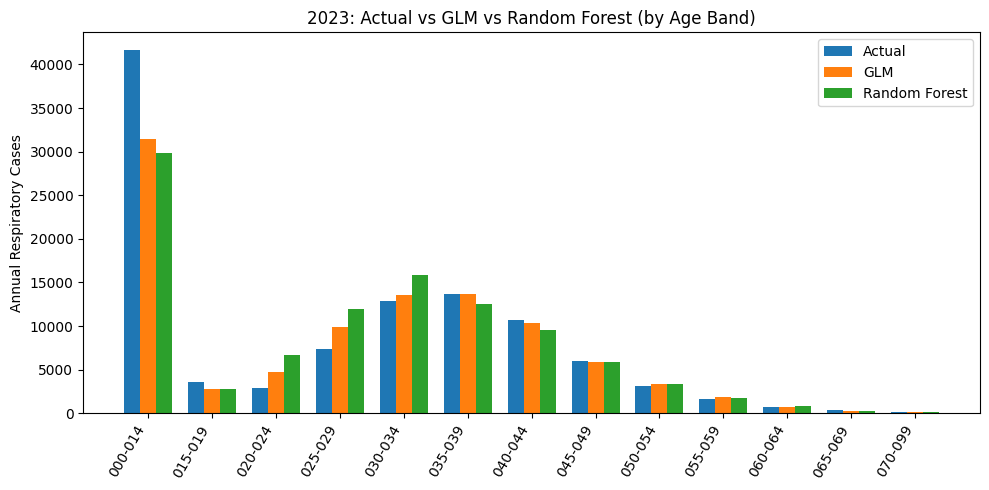

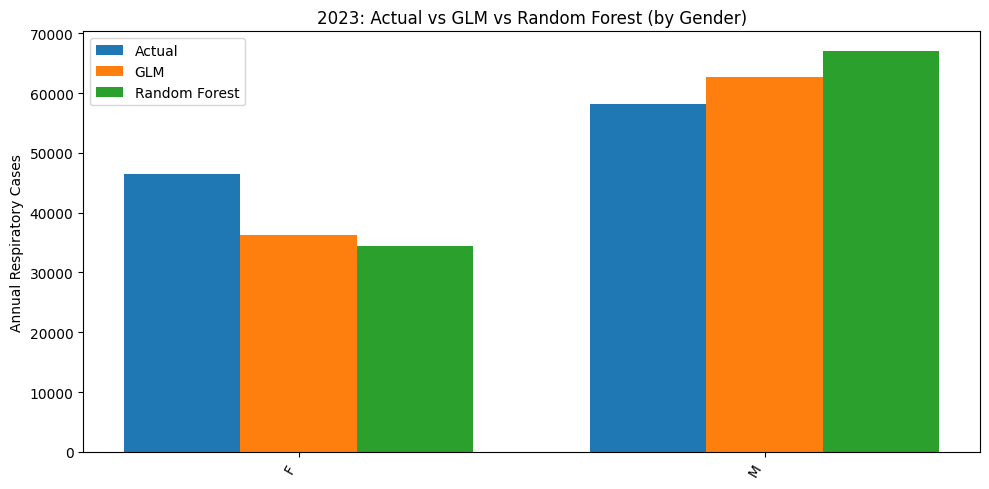

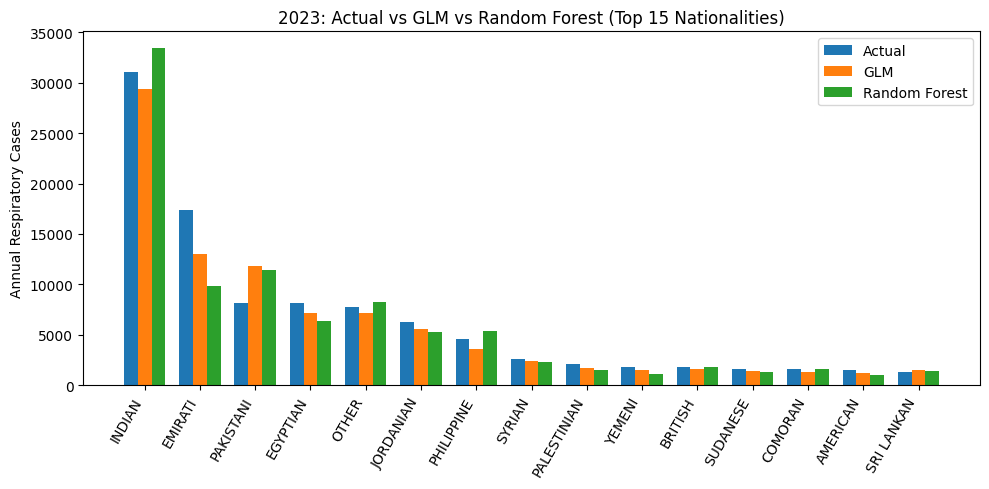

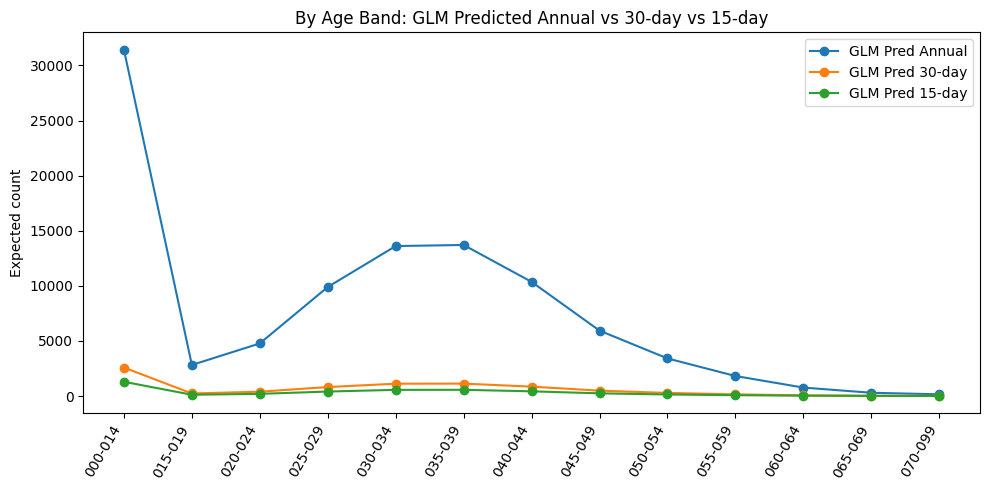

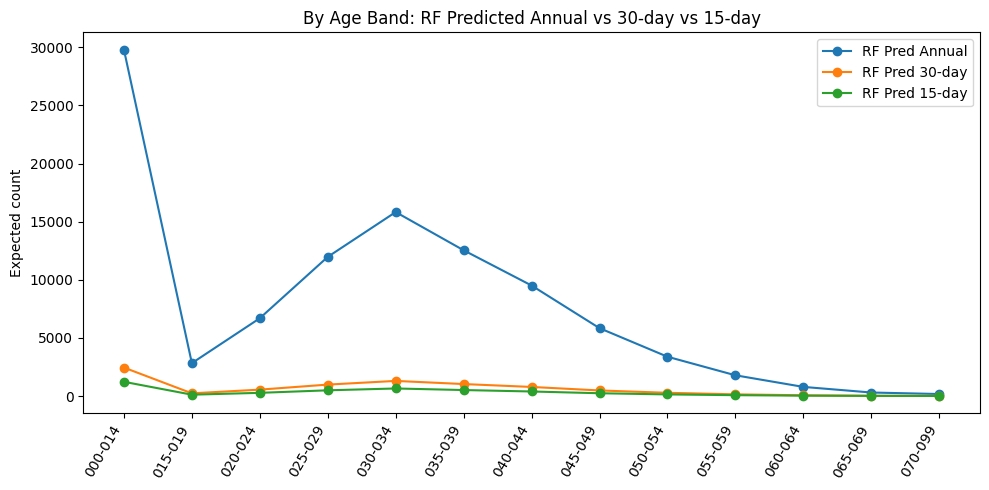

,Model,MAE_AgeBand
0,GLM,1320.286857
1,Random Forest,2080.381063


In [10]:
# ============================================================
# 8) PLOTS (Actual vs GLM vs RF) + Age horizons (Annual/30d/15d)
# ============================================================
def plot_actual_glm_rf(tbl: pd.DataFrame, x_col: str, title: str, top_n: int = None):
    t = tbl.copy()
    if top_n is not None:
        t = t.sort_values("actual_annual", ascending=False).head(top_n)
    else:
        t = t.sort_values(x_col)

    x = np.arange(len(t))
    w = 0.25

    plt.figure(figsize=(max(10, len(t) * 0.5), 5))
    plt.bar(x - w, t["actual_annual"], width=w, label="Actual")
    plt.bar(x,     t["glm_annual"],    width=w, label="GLM")
    plt.bar(x + w, t["rf_annual"],     width=w, label="Random Forest")
    plt.xticks(x, t[x_col].astype(str).values, rotation=60, ha="right")
    plt.ylabel("Annual Respiratory Cases")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_age_pred_horizons(tbl_age: pd.DataFrame, model_prefix: str):
    t = tbl_age.sort_values("AGEBAND").copy()
    x = np.arange(len(t))

    plt.figure(figsize=(max(10, len(t) * 0.5), 5))
    plt.plot(x, t[f"{model_prefix}_annual"].values, marker="o", label=f"{model_prefix.upper()} Pred Annual")
    plt.plot(x, t[f"{model_prefix}_30d"].values,    marker="o", label=f"{model_prefix.upper()} Pred 30-day")
    plt.plot(x, t[f"{model_prefix}_15d"].values,    marker="o", label=f"{model_prefix.upper()} Pred 15-day")
    plt.xticks(x, t["AGEBAND"].astype(str).values, rotation=60, ha="right")
    plt.ylabel("Expected count")
    plt.title(f"By Age Band: {model_prefix.upper()} Predicted Annual vs 30-day vs 15-day")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plots requested
plot_actual_glm_rf(age_cmp, "AGEBAND", "2023: Actual vs GLM vs Random Forest (by Age Band)")
plot_actual_glm_rf(gender_cmp, "gender", "2023: Actual vs GLM vs Random Forest (by Gender)")
plot_actual_glm_rf(nat_cmp, "nationality_grp",
                   f"2023: Actual vs GLM vs Random Forest (Top {TOP_N_NATIONALITIES_PLOT} Nationalities)",
                   top_n=TOP_N_NATIONALITIES_PLOT)

# Age: annual vs 30d vs 15d for each model
plot_age_pred_horizons(age_cmp, "glm")
plot_age_pred_horizons(age_cmp, "rf")

# Optional quick metric (age-band totals)
glm_mae_age = mean_absolute_error(age_cmp["actual_annual"], age_cmp["glm_annual"])
rf_mae_age  = mean_absolute_error(age_cmp["actual_annual"], age_cmp["rf_annual"])

pd.DataFrame({"Model": ["GLM", "Random Forest"], "MAE_AgeBand": [glm_mae_age, rf_mae_age]})
